[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

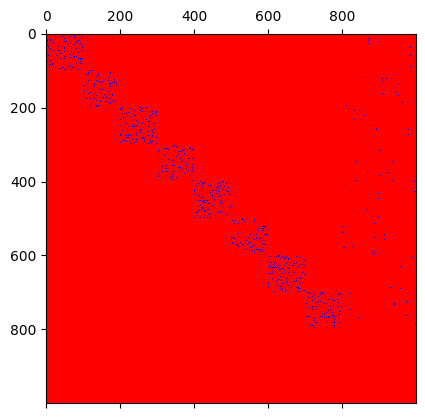

In [61]:
from iznetwork import IzNetwork
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random


N_MODULE = 8
N_MODULE_EXCITATORY = 100
N_EXCITATORY = N_MODULE_EXCITATORY * N_MODULE
N_INHIBITORY = 200

N_MODULE_EDGE = 1000

N = N_INHIBITORY + N_EXCITATORY

Dmax = 20
net = IzNetwork(N, Dmax)

# Set connectivity and delay matrices
W = np.zeros((N,N))
D = np.ones((N,N), dtype=int)

# Connect Modular Excitatory-excitatory (1000 Connections)
for i in range(N_MODULE):
    matrix = np.zeros((N_MODULE_EXCITATORY, N_MODULE_EXCITATORY), dtype=int)
    random_indices = np.random.choice(N_MODULE_EXCITATORY * N_MODULE_EXCITATORY, N_MODULE_EDGE, replace=False)
    matrix[np.unravel_index(random_indices, matrix.shape)] = 1
    W[i * N_MODULE_EXCITATORY:(i + 1) * N_MODULE_EXCITATORY, i * N_MODULE_EXCITATORY:(i + 1) * N_MODULE_EXCITATORY] = matrix

# Connect Excitatory-inhibitory (4 to 1)
for i in range(N_INHIBITORY):
    module_index = np.random.randint(0, N_MODULE)
    neuron_indices = np.random.choice(N_MODULE_EXCITATORY, 4, replace=False)
    for index in neuron_indices:
        # W[module_index * N_MODULE_EXCITATORY + index][N_EXCITATORY + i] = random.uniform(0.0, 1.0)
        W[module_index * N_MODULE_EXCITATORY + index][N_EXCITATORY + i] = 1
    


# Connect Inhibitory-excitatory
W[N_EXCITATORY:, :N_EXCITATORY] = np.random.uniform(-1, 0, size=(N_INHIBITORY, N_EXCITATORY))

# Connect Inhibitory-inhibitory

# Rewire Excitatory-excitatory

# Plot

print(W[:][N_EXCITATORY])

colors = ['red', 'white', 'blue'] 
cmap = mcolors.LinearSegmentedColormap.from_list('red_white_blue', colors)
fig, ax = plt.subplots()
ax.matshow(W, cmap=cmap)
plt.show()

# All neurons are heterogeneous excitatory regular spiking
r = np.random.rand(N)
a = 0.02*np.ones(N)
b = 0.2*np.ones(N)
c = -65 + 15*(r**2)
d = 8 - 6*(r**2)

net.setWeights(W)
net.setDelays(D)
net.setParameters(a, b, c, d)

T = 500
V = np.zeros((T, N))
for t in range(T):
    net.setCurrent(5*np.ones(N))
    net.update()
    V[t,:], _ = net.getState()

t, n = np.where(V > 29)
# plt.scatter(t, n)
# plt.xlabel('Time (ms)')
# plt.ylabel('Neuron index')
# plt.show()
